### NASA IMAGE EXTRACTION

In [2]:
#Installation of nasapy api
!pip install nasapy

In [3]:
#Installation of gtts(Google To Text Speech)
!pip install gtts


In [6]:
import os
os.environ["NASA_API_KEY"] = "rfyEpeDgpsZBVU1YwirDcaLjvYsNbKCNVI1aFdKd"


Enter date (YYYY-MM-DD) between 1996-01-01 and today: 2000-11-19
✔ Validated date: 2000-11-19

NASA APOD Information

📅 Date: 2000-11-19
📌 Title: Our Dusty Universe

📝 Description:

What's black & white and red all over?  Add our universe to this list.  Adrift in a vast sea of darkness are not only familiar bright stars but dust that glows predominantly in far-infrared light.  This cosmological dust was recently discovered in data taken previously by the COBE satellite, and visible as a diffuse glow visible in the above image.  The amount of dust in the universe is important because it is a measure of the number of stars that created it, of the number of stars that are cloaked by it, and of the amount of distortion created in measurements of the distant universe.


🖼 Media Type: IMAGE

✔ Image Downloaded Successfully


🔊 Type 'a' to hear audio explanation: a


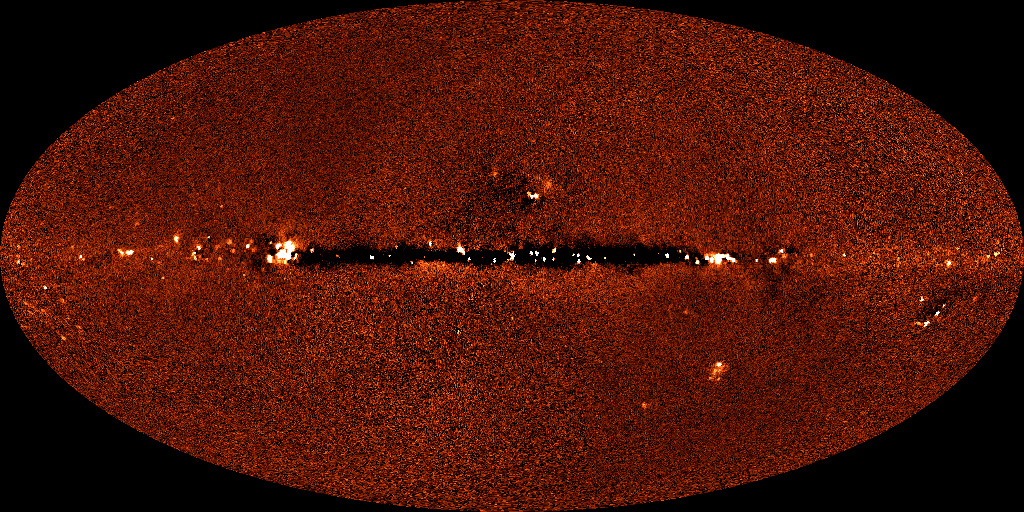


🎧 Generating audio... Please wait...
✔ Audio Ready! Playing now...



In [10]:
# ---------------------------------------------
# NASA APOD Fetcher (Works in Windows + Colab)
# Supports: Image + Video + Audio Explanation
# ---------------------------------------------

import nasapy
import os
from datetime import datetime
import urllib.request
from IPython.display import Image, display, YouTubeVideo, Audio
from gtts import gTTS

# Read API key
api_key = os.environ.get("NASA_API_KEY")

if api_key is None:
    raise ValueError("NASA_API_KEY is not set. Run the first cell.")

# Initialize NASA object
nasa = nasapy.Nasa(key=api_key)


# -------------------------------
# Validate Date Function
# -------------------------------
def validate_date(date_str):
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d').date()
        today = datetime.now().date()

        if datetime.strptime("1996-01-01", "%Y-%m-%d").date() <= date <= today:
            return True
        return False

    except ValueError:
        return False


# -------------------------------
# Ask user for valid date
# -------------------------------
while True:
    user_date = input("Enter date (YYYY-MM-DD) between 1996-01-01 and today: ")
    if validate_date(user_date):
        break
    print("❌ Invalid date. Try again.\n")

print("✔ Validated date:", user_date)

# -------------------------------
# Fetch APOD Data
# -------------------------------
apod = nasa.picture_of_the_day(date=user_date, hd=True)

print("\n==============================")
print("NASA APOD Information")
print("==============================\n")

# Print APOD info
print(f"📅 Date: {apod.get('date', 'N/A')}")
print(f"📌 Title: {apod.get('title', 'N/A')}\n")
print("📝 Description:\n")
print(apod.get("explanation", "No description available."))
print("\n")


# -------------------------------
# IMAGE HANDLING
# -------------------------------
if apod["media_type"] == "image":
    print("🖼 Media Type: IMAGE\n")

    img_dir = "Astro_Images"
    os.makedirs(img_dir, exist_ok=True)

    title_clean = apod["title"].replace(" ", "_").replace(":", "_")
    filename = f"{user_date}_{title_clean}.jpg"

    # Download HD image
    urllib.request.urlretrieve(apod["hdurl"], os.path.join(img_dir, filename))

    print("✔ Image Downloaded Successfully\n")
    display(Image(os.path.join(img_dir, filename)))

# -------------------------------
# VIDEO HANDLING
# -------------------------------
elif apod["media_type"] == "video":
    print("🎥 Media Type: VIDEO\n")

    url = apod["url"]

    # If YouTube video, embed it
    if "youtube" in url or "youtu.be" in url:
        print("✔ YouTube video detected. Playing below:\n")
        video_id = url.split("/")[-1].replace("watch?v=", "")
        display(YouTubeVideo(video_id))
    else:
        print("Video URL (not YouTube):")
        print(url)

# -------------------------------
# OTHER MEDIA TYPES
# -------------------------------
else:
    print("⚠ Media Type Not Supported:", apod["media_type"])


# -------------------------------
# AUDIO DESCRIPTION (TTS)
# -------------------------------
choice = input("\n🔊 Type 'a' to hear audio explanation: ")

if choice.lower() == "a":
    print("\n🎧 Generating audio... Please wait...")

    text = apod["explanation"]
    audio_dir = "Astro_Images"
    os.makedirs(audio_dir, exist_ok=True)

    audio_file = os.path.join(audio_dir, f"{user_date}_audio.mp3")

    tts = gTTS(text=text, lang="en")
    tts.save(audio_file)

    print("✔ Audio Ready! Playing now...\n")
    display(Audio(audio_file, autoplay=True))
